In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 4 AutoEncoder: Comparitive Analysis

### 4.2 CNN AutoEncoder

#### 4.2.1 Dataset Analysis and Preprocessing

In [3]:
ae_train_data_path = "./../../data/external/fashion_mnist/fashion_mnist_train.csv"
ae_test_data_path = "./../../data/external/fashion_mnist/fashion_mnist_test.csv"

ae_train_data = pd.read_csv(ae_train_data_path)
ae_test_data = pd.read_csv(ae_test_data_path)

ae_val_data = ae_train_data.iloc[len(ae_train_data) - len(ae_test_data):]
ae_train_data = ae_train_data.iloc[:len(ae_train_data) - len(ae_test_data)]

ae_train_x = ae_train_data.drop('label', axis=1).values
ae_train_y = ae_train_data['label'].values

ae_val_x = ae_val_data.drop('label', axis=1).values
ae_val_y = ae_val_data['label'].values

ae_test_x = ae_test_data.drop('label', axis=1).values
ae_test_y = ae_test_data['label'].values

ae_train_x = ae_train_x/255.0
ae_val_x = ae_val_x/255.0
ae_test_x = ae_test_x/255.0

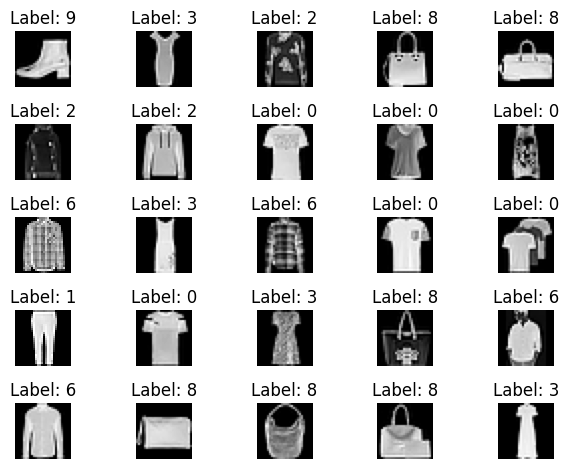

In [4]:
ae_train_data_sample = ae_train_data.sample(40)

ae_images = ae_train_data_sample.drop('label', axis=1).values
ae_labels = ae_train_data_sample['label'].values
ae_labels = ae_labels

ae_images = ae_images.reshape(-1, 28, 28)

ae_images = [Image.fromarray((image).astype(np.uint8)) for image in ae_images]

fig, axes = plt.subplots(5, 5)

for i, ax in enumerate(axes.flat):
    ax.imshow(ae_images[i], cmap='gray')
    ax.set_title(f"Label: {ae_labels[i]}")
    ax.axis('off')

plt.tight_layout()

(3)

| Label | Category       |
|-------|----------------|
| 0     | T-Shirts       |
| 1     | Pants          |
| 2     | Shirt          |
| 3     | Women Dress    |
| 4     | Women Dress    |
| 5     | Sandals        |
| 6     | Bags           |
| 7     | Shoes          |
| 8     | Women Bags     |
| 9     | High Heel Shoes|


#### 4.2.2 Implement the CnnAutoencoder class

In [5]:
class CnnAutoencoder(nn.Module):
    def __init__(self, input_channels=1, filter_sizes=[16, 32, 64], kernel_size=5):
        super(CnnAutoencoder, self).__init__()

        if (len(filter_sizes)==2):
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, filter_sizes[0], kernel_size, stride=2, padding=2),
                nn.ReLU(),
                nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size, stride=2, padding=2)
            )

            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(filter_sizes[1], filter_sizes[0], kernel_size, stride=2, padding=2, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(filter_sizes[0], input_channels, kernel_size, stride=2, padding=2, output_padding=1),
                nn.Sigmoid()
            )

        elif (len(filter_sizes)==3):
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, filter_sizes[0], kernel_size, stride=2, padding=kernel_size//2),
                nn.ReLU(),
                nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size, stride=2, padding=kernel_size//2),
                nn.ReLU(),
                nn.Conv2d(filter_sizes[1], filter_sizes[2], kernel_size, stride=1, padding=0)
            )
            
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(filter_sizes[2], filter_sizes[1], kernel_size, stride=1, padding=0),
                nn.ReLU(),
                nn.ConvTranspose2d(filter_sizes[1], filter_sizes[0], kernel_size, stride=2, padding=kernel_size//2, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(filter_sizes[0], input_channels, kernel_size, stride=2, padding=kernel_size//2, output_padding=1),
                nn.Sigmoid()
            )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu', tune=False):
        self.to(device)
        train_losses, val_losses = [], []
        for epoch in range(num_epochs):
            self.train()
            if not tune:
                train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            else:
                train_progress = enumerate(train_loader)

            total_train_loss = 0
            for i, (x, _) in train_progress:
                x = x.to(device)
                optimizer.zero_grad()
                y_pred = self(x)
                loss = self.loss(y_pred, x)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            val_loss = self.evaluate(val_loader, device)
            
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            
            if not tune:
                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        return train_losses, val_losses


#### 4.2.3 Plots and Visualizations

In [6]:
class MultiMNISTDataset_ae(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image.reshape(-1, 28, 28), dtype=torch.float32)
        return image, label

In [7]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
val_data_ae = MultiMNISTDataset_ae(ae_val_x, ae_val_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=True)
val_loader_ae = DataLoader(val_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

In [8]:
autoencoder = CnnAutoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
_,_ = autoencoder.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 1563/1563 [00:16<00:00, 95.14it/s] 


Epoch 1/10, Train Loss: 0.0162, Validation Loss: 0.0081


Epoch 2/10: 100%|██████████| 1563/1563 [00:12<00:00, 123.53it/s]


Epoch 2/10, Train Loss: 0.0068, Validation Loss: 0.0057


Epoch 3/10: 100%|██████████| 1563/1563 [00:12<00:00, 122.56it/s]


Epoch 3/10, Train Loss: 0.0050, Validation Loss: 0.0044


Epoch 4/10: 100%|██████████| 1563/1563 [00:14<00:00, 108.36it/s]


Epoch 4/10, Train Loss: 0.0040, Validation Loss: 0.0035


Epoch 5/10: 100%|██████████| 1563/1563 [00:13<00:00, 118.69it/s]


Epoch 5/10, Train Loss: 0.0033, Validation Loss: 0.0031


Epoch 6/10: 100%|██████████| 1563/1563 [00:13<00:00, 117.17it/s]


Epoch 6/10, Train Loss: 0.0028, Validation Loss: 0.0026


Epoch 7/10: 100%|██████████| 1563/1563 [00:13<00:00, 118.33it/s]


Epoch 7/10, Train Loss: 0.0025, Validation Loss: 0.0029


Epoch 8/10: 100%|██████████| 1563/1563 [00:15<00:00, 103.31it/s]


Epoch 8/10, Train Loss: 0.0023, Validation Loss: 0.0022


Epoch 9/10: 100%|██████████| 1563/1563 [00:16<00:00, 93.70it/s] 


Epoch 9/10, Train Loss: 0.0021, Validation Loss: 0.0021


Epoch 10/10: 100%|██████████| 1563/1563 [00:14<00:00, 105.00it/s]


Epoch 10/10, Train Loss: 0.0020, Validation Loss: 0.0020


In [9]:
def plot_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            y_pred = model(x)
            break

    x = x.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(15, 5))
    fig.subplots_adjust(hspace=0.4)
    for i in range(10):
        axes[0, i].imshow(x[i].reshape(28, 28), cmap='gray')
        axes[1, i].imshow(y_pred[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[0, i].set_title("Original")
        axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()


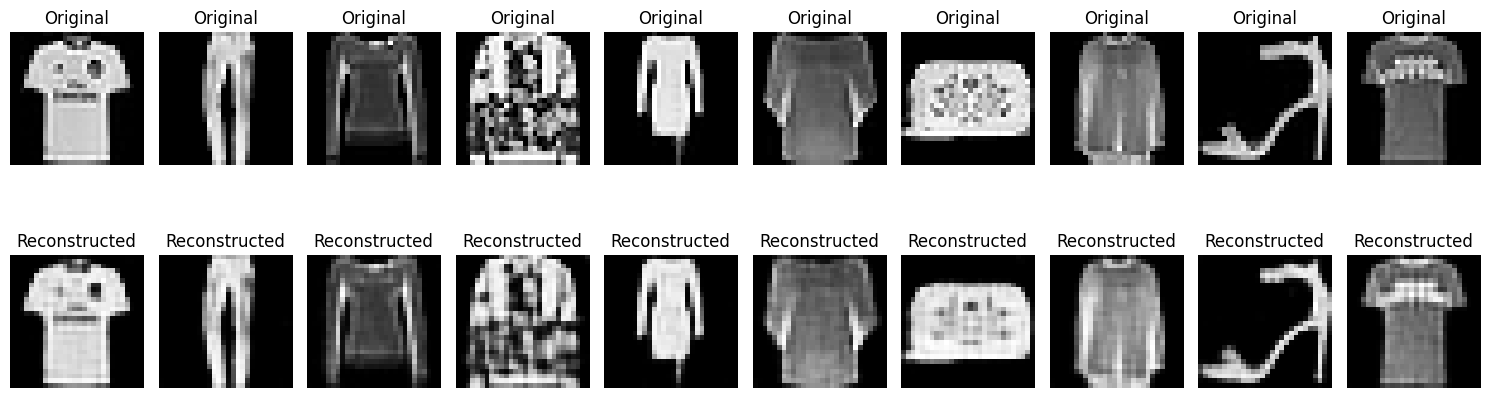

In [10]:
plot_reconstruction(autoencoder, test_loader_ae)

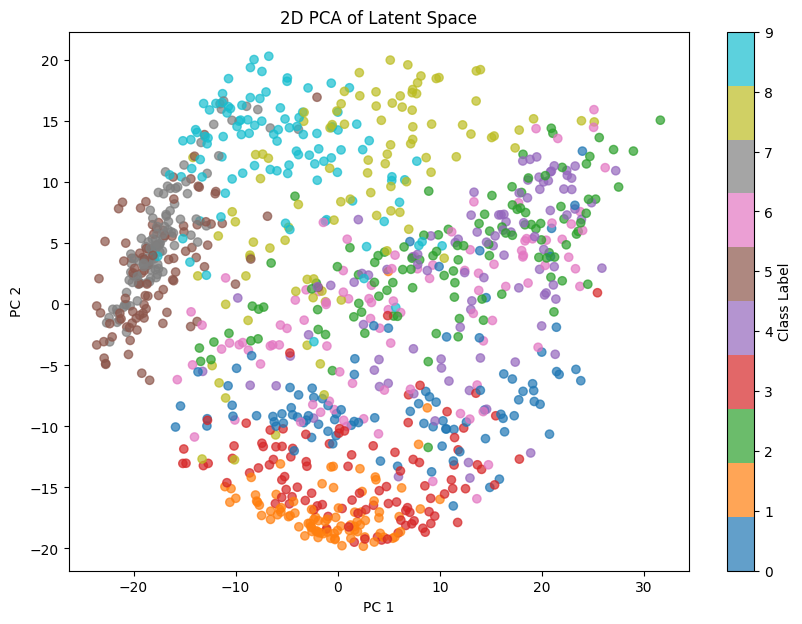

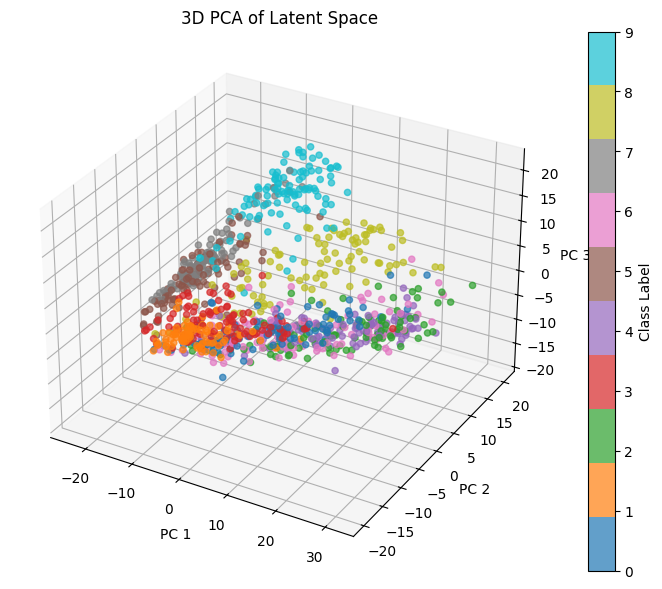

In [11]:
from sklearn.decomposition import PCA

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(autoencoder, test_loader_ae)


Observations:
- The Label with similar category are closer to each other for example T-Shirts and Pants are closer to each other, footwear are closer to each other, bags are closer to each other.
- The 3d plot is more clear and easy to understand in terms of clusters.

#### Hyperparameter Tuning

In [12]:
from itertools import product

configs = {
    'learning_rate': [0.001, 0.0005],
    'kernel_size': [3, 5],
    'filter_sizes': [[16, 32, 64]],
    'optimizer': [torch.optim.Adam, torch.optim.SGD]
}

best_val_loss = float('inf')
best_config = None

for lr, ks, fltrs, opt in product(*configs.values()):
    print(f"Training with Learning Rate: {lr}, Kernel Size: {ks}, Filter Sizes: {fltrs}, Optimizer: {opt.__name__}")
    model = CnnAutoencoder(kernel_size=ks, filter_sizes=fltrs).to(device)
    optimizer = opt(model.parameters(), lr=lr)
    
    train_losses, val_losses = model.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device, tune=True)
    final_val_loss = val_losses[-1]
    print(f"Final Validation Loss: {val_losses[-1]}")

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_config = {'learning_rate': lr, 'kernel_size': ks, 'filters': fltrs, 'optimizer': opt.__name__}

print("Best Configuration:", best_config)
print("Validation Loss:", best_val_loss)


Training with Learning Rate: 0.001, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.001237141234746661
Training with Learning Rate: 0.001, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Validation Loss: 0.12713870560875334
Training with Learning Rate: 0.001, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.0019429626970584638
Training with Learning Rate: 0.001, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Validation Loss: 0.12652039811157953
Training with Learning Rate: 0.0005, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.0016564605995631827
Training with Learning Rate: 0.0005, Kernel Size: 3, Filter Sizes: [16, 32, 64], Optimizer: SGD
Final Validation Loss: 0.13627698955634912
Training with Learning Rate: 0.0005, Kernel Size: 5, Filter Sizes: [16, 32, 64], Optimizer: Adam
Final Validation Loss: 0.0029338247376306656
Training with Learni

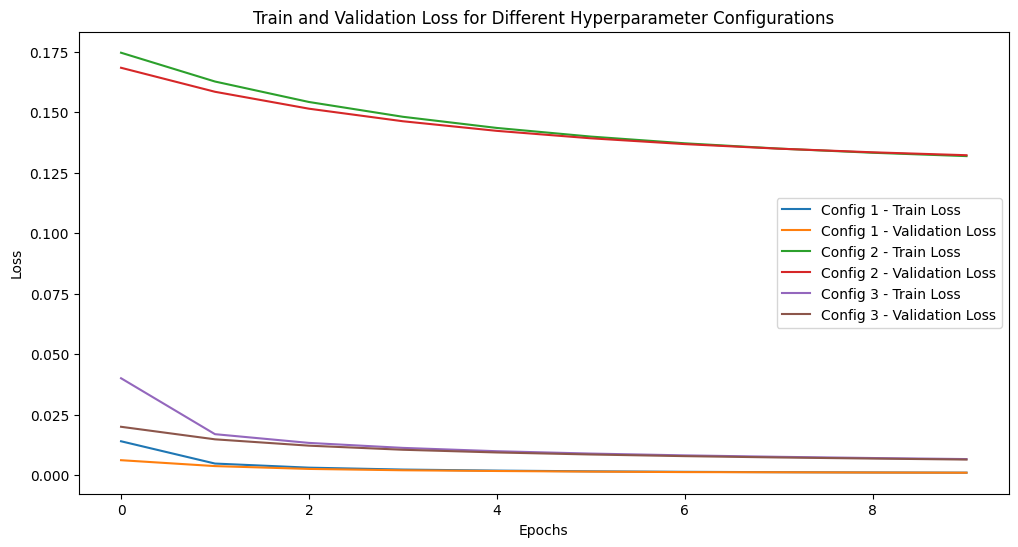

In [13]:
def train_and_plot(model, optimizer, config_name):
    train_losses, val_losses = model.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device, tune=True)
    plt.plot(train_losses, label=f"{config_name} - Train Loss")
    plt.plot(val_losses, label=f"{config_name} - Validation Loss")

configs_to_plot = [
    {'learning_rate': 0.001, 'kernel_size': 3, 'filters': [16, 32, 64], 'optimizer': torch.optim.Adam},
    {'learning_rate': 0.0005, 'kernel_size': 3, 'filters': [32, 64, 128], 'optimizer': torch.optim.SGD},
    {'learning_rate': 0.0001, 'kernel_size': 5, 'filters': [16, 32, 64], 'optimizer': torch.optim.Adam}
]

plt.figure(figsize=(12, 6))
for i, config in enumerate(configs_to_plot):
    model = CnnAutoencoder(kernel_size=config['kernel_size'], filter_sizes=config['filters']).to(device)
    optimizer = config['optimizer'](model.parameters(), lr=config['learning_rate'])
    train_and_plot(model, optimizer, f"Config {i + 1}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss for Different Hyperparameter Configurations")
plt.show()


The best performing model is the one with the following hyperparameters(config 1):
| Hyperparameter | Value |
|----------------|-------|
| Learning Rate  | 0.001 |
| Kernel Size    | 3     |
| Filter Sizes   | [16, 32, 64]|
| Optimizer      | Adam  |

Training with Depth: 2
Training with Depth: 3


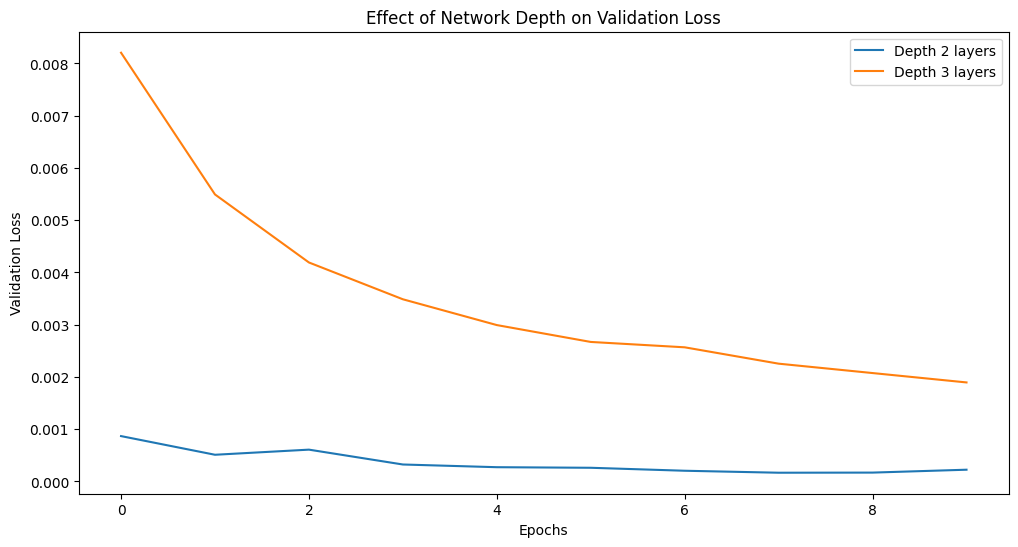

In [14]:
depth_configs = [
    [32, 64],
    [16, 32, 64],
    # [8, 16, 32, 64] 
]

plt.figure(figsize=(12, 6))

for depth in depth_configs:
    model = CnnAutoencoder(filter_sizes=depth).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training with Depth: {len(depth)}")
    train_losses, val_losses = model.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device, tune=True)
    plt.plot(val_losses, label=f"Depth {len(depth)} layers")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Effect of Network Depth on Validation Loss")
plt.show()


Observations:
- From the above plot we can see the loss increases with increase in depth of the model while keeping all other hyperparameters constant.

### 4.3 MLP AutoEncoder

In [15]:
import sys
sys.path.append('./../../')

In [16]:
from models.autoencoder.autoencoder import AutoEncoder

input_dim = ae_train_x.shape[1]
latent_dim = 68
neurons_per_layer = [128] 
mlp_autoencoder = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, neurons_per_layer=neurons_per_layer, learning_rate=0.001, n_epochs=30, batch_size=32)

In [17]:
mlp_autoencoder.fit(ae_train_x)

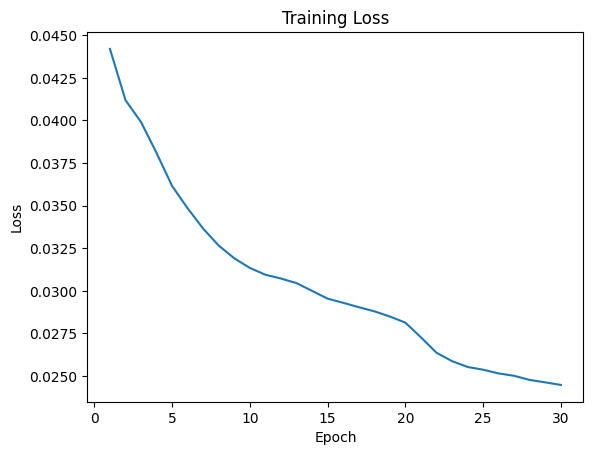

In [18]:
epochs = range(1, mlp_autoencoder.autoencoder.n_epochs + 1)
plt.plot(epochs, mlp_autoencoder.autoencoder.loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Comparison with CNN AutoEncoder:
- The CNN AutoEncoder converges faster than the MLP AutoEncoder.
- The loss is lower for CNN AutoEncoder than MLP AutoEncoder.

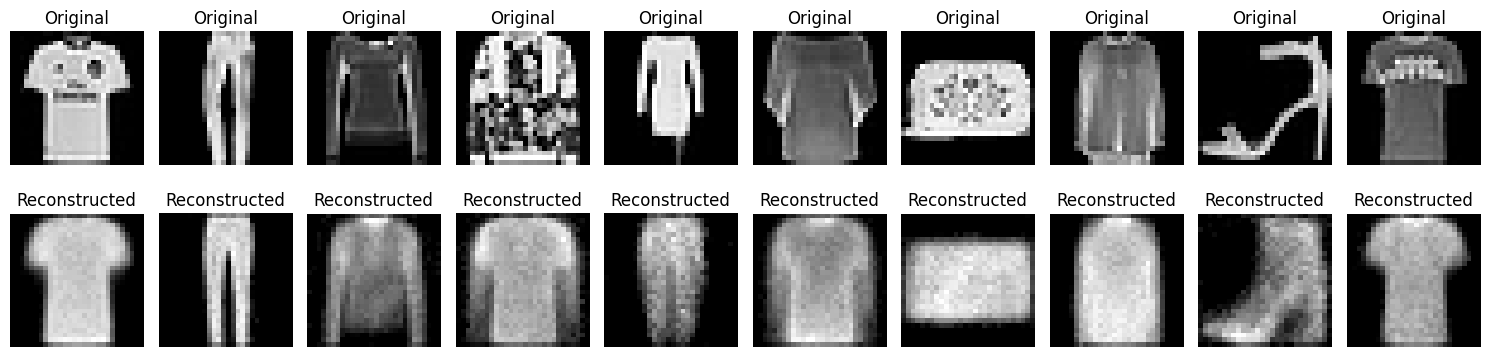

In [19]:
test_reconstructions = mlp_autoencoder.reconstruct(ae_test_x[:10])

original_images = ae_test_x[:10].reshape(-1, 28, 28)
reconstructed_images = test_reconstructions.reshape(-1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(original_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


Comparison with CNN AutoEncoder:
- The Reconstructions in CNN AutoEncoder are more clear and accurate than MLP AutoEncoder.
- This is because the loss is lower for CNN AutoEncoder than MLP AutoEncoder.

### 4.4 PCA Autoencoder

#### 4.4.1 Implement the PcaAutoencoder Class

In [20]:
from models.pca.pca import PCA

class PCA_autoencoder:
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.pca = PCA(latent_dim)
    
    def fit(self, x):
        self.pca.fit(x)

    def encode(self, x):
        return self.pca.transform(x)

    def forward(self, x):
        x_encoded = self.encode(x)
        return np.dot(x_encoded, self.pca.eig_vectors[:, :self.latent_dim].T) + self.pca.means

#### 4.4.2 Estimate optimal number of components

In [21]:
def estimate_optimal_components(X_train, X_val, max_components=100):
    mse_errors = []
    component_range = range(1, max_components + 1)

    for n_components in component_range:
        pca_autoencoder = PCA_autoencoder(latent_dim=n_components)
        pca_autoencoder.fit(X_train)
        X_val_reconstructed = pca_autoencoder.forward(X_val)
        mse = np.mean((X_val - X_val_reconstructed) ** 2)
        mse_errors.append(mse)

    plt.plot(component_range, mse_errors)
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot of Reconstruction Error vs Number of Components")
    plt.show()

    k_optimal = 1
    for i in range(1, len(mse_errors) - 1):
        if mse_errors[i]<0.01:
            k_optimal = i
            break
    
    print(f"Optimal Number of Components: {k_optimal}")

    return k_optimal, mse_errors

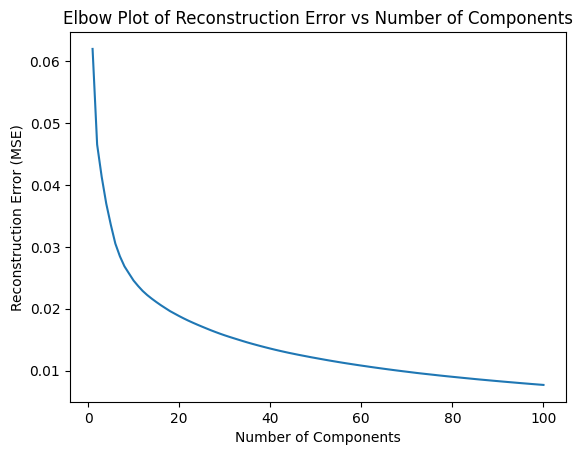

Optimal Number of Components: 68


In [22]:
k_optimal, mse_errors = estimate_optimal_components(ae_train_x, ae_val_x, max_components=100)

In [23]:
def visualize_reconstructions(pca_autoencoder, X_test, num_images=10):
    X_reconstructed = pca_autoencoder.forward(X_test)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

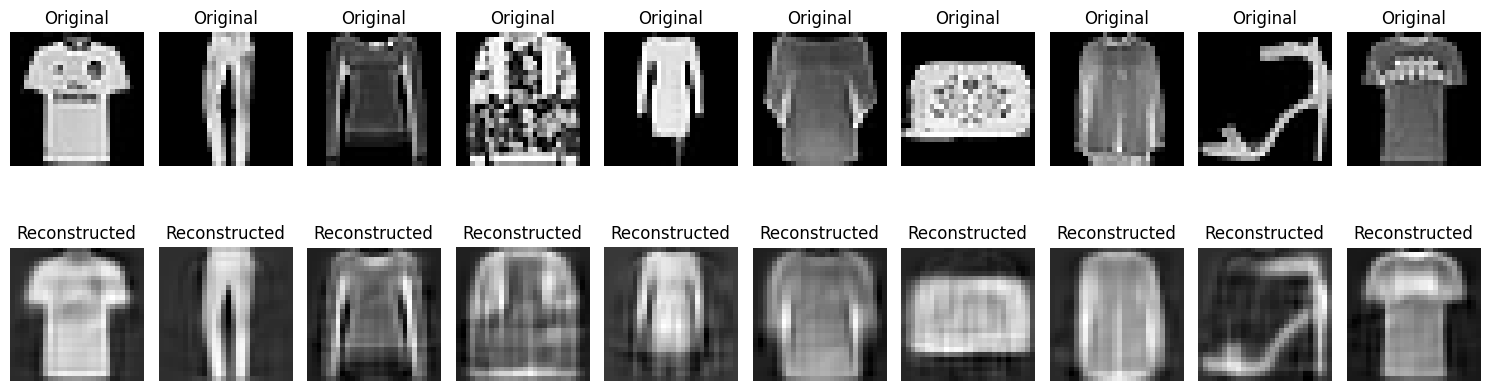

In [24]:
pca_autoencoder = PCA_autoencoder(latent_dim=k_optimal)
pca_autoencoder.fit(ae_train_x)

visualize_reconstructions(pca_autoencoder, ae_test_x[:10])

Comparison with CNN AutoEncoder and MLP AutoEncoder:
- The reconstructions of pca autoencoder are blurrier than CNN AutoEncoder and MLP AutoEncoder.
- Although in terms of preserving shape of the object, it is better than MLP AutoEncoder.
- The background in case of PCA AutoEncoder is less black than CNN AutoEncoder and MLP AutoEncoder.

### 4.5 KNN Classification

In [25]:
class CnnAutoencoder_knn(nn.Module):
    def __init__(self):
        super(CnnAutoencoder_knn, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, k_optimal, 7)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(k_optimal, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for x, _ in data_loader:
                x = x.to(device)
                y_pred = self.forward(x)
                loss = self.loss(y_pred, x)
                total_loss += loss.item()
        return total_loss / len(data_loader)
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, _) in train_progress:
                x = x.to(device)
                optimizer.zero_grad()
                y_pred = self(x)
                loss = self.loss(y_pred, x)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            val_loss = self.evaluate(val_loader, device)
            print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.6f}")


In [26]:
autoencoder_knn = CnnAutoencoder_knn().to(device)
optimizer = torch.optim.Adam(autoencoder_knn.parameters(), lr=0.001)
autoencoder_knn.train_model(optimizer, train_loader_ae, val_loader_ae, num_epochs=10, device=device)

Epoch 1/10: 100%|██████████| 1563/1563 [00:16<00:00, 97.29it/s, Loss=0.0083] 


Epoch 1, Validation Loss: 0.011329


Epoch 2/10: 100%|██████████| 1563/1563 [00:14<00:00, 106.74it/s, Loss=0.0111]


Epoch 2, Validation Loss: 0.008769


Epoch 3/10: 100%|██████████| 1563/1563 [00:15<00:00, 102.83it/s, Loss=0.0079]


Epoch 3, Validation Loss: 0.007534


Epoch 4/10: 100%|██████████| 1563/1563 [00:15<00:00, 103.78it/s, Loss=0.0058]


Epoch 4, Validation Loss: 0.006879


Epoch 5/10: 100%|██████████| 1563/1563 [00:15<00:00, 103.98it/s, Loss=0.0059]


Epoch 5, Validation Loss: 0.006523


Epoch 6/10: 100%|██████████| 1563/1563 [00:15<00:00, 101.63it/s, Loss=0.0071]


Epoch 6, Validation Loss: 0.006341


Epoch 7/10: 100%|██████████| 1563/1563 [00:14<00:00, 105.15it/s, Loss=0.0054]


Epoch 7, Validation Loss: 0.006079


Epoch 8/10: 100%|██████████| 1563/1563 [00:16<00:00, 97.00it/s, Loss=0.0050] 


Epoch 8, Validation Loss: 0.005975


Epoch 9/10: 100%|██████████| 1563/1563 [00:15<00:00, 103.90it/s, Loss=0.0038]


Epoch 9, Validation Loss: 0.005877


Epoch 10/10: 100%|██████████| 1563/1563 [00:24<00:00, 64.24it/s, Loss=0.0041]


Epoch 10, Validation Loss: 0.005785


In [27]:
train_data_ae = MultiMNISTDataset_ae(ae_train_x, ae_train_y)
test_data_ae = MultiMNISTDataset_ae(ae_test_x, ae_test_y)

train_loader_ae = DataLoader(train_data_ae, batch_size=32, shuffle=False)
test_loader_ae = DataLoader(test_data_ae, batch_size=32, shuffle=False)

ae_train_x_encoded_cnn = []
ae_test_x_encoded_cnn = []

autoencoder_knn.eval()
with torch.no_grad():
    for x, _ in train_loader_ae:
        x = x.to(device)
        encoded = autoencoder_knn.encode(x)
        ae_train_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

    for x, _ in test_loader_ae:
        x = x.to(device)
        encoded = autoencoder_knn.encode(x)
        ae_test_x_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())

ae_train_x_encoded_cnn = np.concatenate(ae_train_x_encoded_cnn)
ae_test_x_encoded_cnn = np.concatenate(ae_test_x_encoded_cnn)

In [28]:
ae_train_x_encoded_mlp = mlp_autoencoder.get_latent(ae_train_x)
ae_test_x_encoded_mlp = mlp_autoencoder.get_latent(ae_test_x)

In [29]:
pca_autoencoder_knn = PCA_autoencoder(latent_dim=k_optimal)
pca_autoencoder_knn.fit(ae_train_x)

In [30]:
ae_train_x_encoded_pca = pca_autoencoder_knn.encode(ae_train_x)
ae_test_x_encoded_pca = pca_autoencoder_knn.encode(ae_test_x)

In [31]:
print(ae_train_x_encoded_cnn.shape, ae_train_x_encoded_mlp.shape, ae_train_x_encoded_pca.shape)
print(ae_test_x_encoded_cnn.shape, ae_test_x_encoded_mlp.shape, ae_test_x_encoded_pca.shape)

(50000, 68) (50000, 68) (50000, 68)
(10000, 68) (10000, 68) (10000, 68)


In [32]:
from models.knn.knn import KNN
from performance_measures.knn_score import Scores

In [33]:
knn_k = 5

In [34]:
knn_cnn = KNN(k=knn_k)
knn_cnn.fit(ae_train_x_encoded_cnn, ae_train_y)
ae_pred_cnn = knn_cnn.predict(ae_test_x_encoded_cnn, distance_metric='cosine')
scores_cnn = Scores(ae_test_y, ae_pred_cnn)
accuracy_cnn_test = scores_cnn.accuracy
ae_pred_train_cnn = knn_cnn.predict(ae_train_x_encoded_cnn, distance_metric='cosine')
scores_cnn_train = Scores(ae_train_y, ae_pred_train_cnn)
accuracy_cnn_train = scores_cnn_train.accuracy
print(f"Accuracy of KNN with CNN Autoencoder on Train: {accuracy_cnn_train*100:.2f}%")
print(f"Accuracy of KNN with CNN Autoencoder on Test: {accuracy_cnn_test*100:.2f}%")


Accuracy of KNN with CNN Autoencoder on Train: 91.85%
Accuracy of KNN with CNN Autoencoder on Test: 88.06%


In [35]:
knn_mlp = KNN(k=knn_k)
knn_mlp.fit(ae_train_x_encoded_mlp, ae_train_y)
ae_pred_mlp = knn_mlp.predict(ae_test_x_encoded_mlp, distance_metric='cosine')
scores_mlp = Scores(ae_test_y, ae_pred_mlp)
accuracy_mlp_test = scores_mlp.accuracy
ae_pred_train_mlp = knn_mlp.predict(ae_train_x_encoded_mlp, distance_metric='cosine')
scores_mlp_train = Scores(ae_train_y, ae_pred_train_mlp)
accuracy_mlp_train = scores_mlp_train.accuracy
print(f"Accuracy of KNN with MLP Autoencoder on Train: {accuracy_mlp_train*100:.2f}%")
print(f"Accuracy of KNN with MLP Autoencoder on Test: {accuracy_mlp_test*100:.2f}%")

Accuracy of KNN with MLP Autoencoder on Train: 78.17%
Accuracy of KNN with MLP Autoencoder on Test: 69.90%


In [36]:
knn_pca = KNN(k=knn_k)
knn_pca.fit(ae_train_x_encoded_pca, ae_train_y)
ae_pred_pca = knn_pca.predict(ae_test_x_encoded_pca, distance_metric='cosine')
scores_pca = Scores(ae_test_y, ae_pred_pca)
accuracy_pca_test = scores_pca.accuracy
ae_pred_train_pca = knn_pca.predict(ae_train_x_encoded_pca, distance_metric='cosine')
scores_pca_train = Scores(ae_train_y, ae_pred_train_pca)
accuracy_pca_train = scores_pca_train.accuracy
print(f"Accuracy of KNN with PCA Autoencoder on Train: {accuracy_pca_train*100:.2f}%")
print(f"Accuracy of KNN with PCA Autoencoder on Test: {accuracy_pca_test*100:.2f}%")

Accuracy of KNN with PCA Autoencoder on Train: 90.34%
Accuracy of KNN with PCA Autoencoder on Test: 86.36%


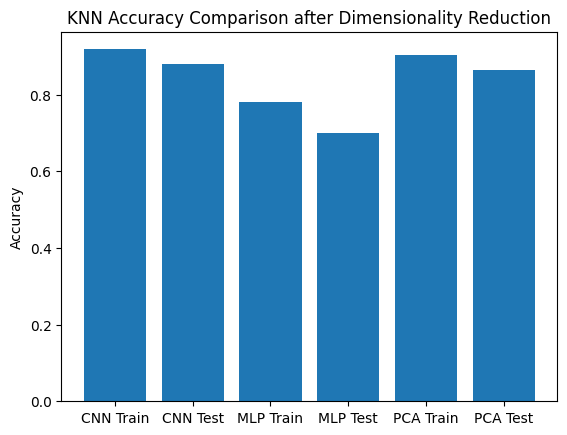

In [37]:
accuracies = [accuracy_cnn_train, accuracy_cnn_test, accuracy_mlp_train, accuracy_mlp_test, accuracy_pca_train, accuracy_pca_test]
labels = ['CNN Train', 'CNN Test', 'MLP Train', 'MLP Test', 'PCA Train', 'PCA Test']

plt.bar(labels, accuracies)
plt.ylabel('Accuracy')
plt.title('KNN Accuracy Comparison after Dimensionality Reduction')
plt.show()

In [38]:
confusion_matrix_cnn = scores_cnn.confusion_matrix
confusion_matrix_mlp = scores_mlp.confusion_matrix
confusion_matrix_pca = scores_pca.confusion_matrix

confusion_matrix_cnn = confusion_matrix_cnn.astype(np.int32)
confusion_matrix_mlp = confusion_matrix_mlp.astype(np.int32)
confusion_matrix_pca = confusion_matrix_pca.astype(np.int32)

In [39]:
import seaborn as sns

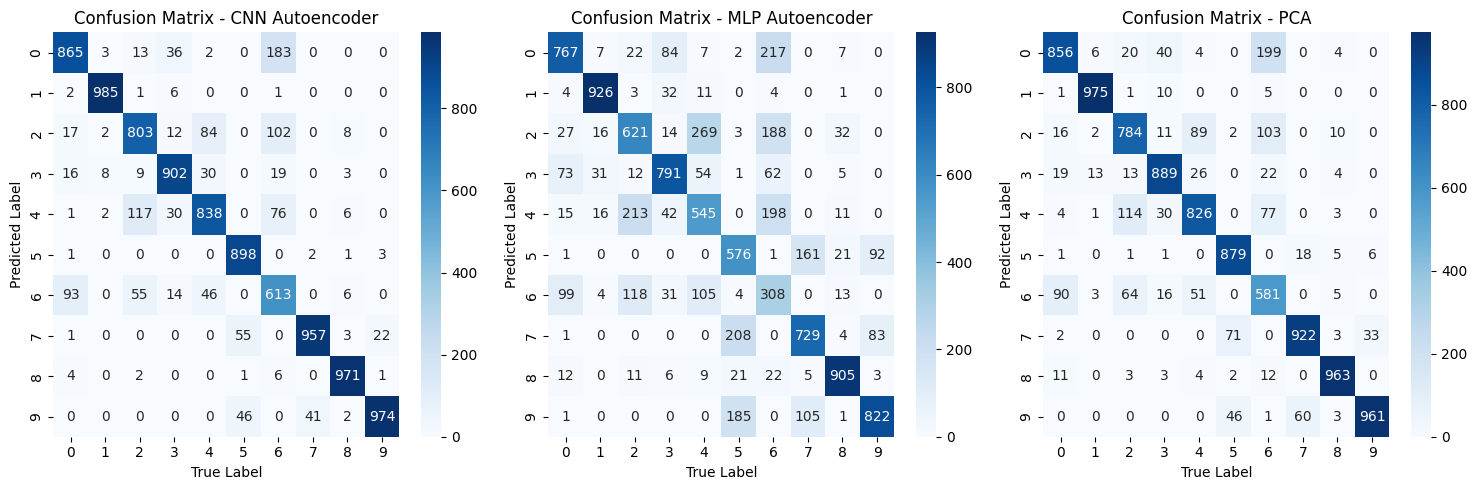

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_matrix_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - CNN Autoencoder')
axes[0].set_xlabel('True Label')
axes[0].set_ylabel('Predicted Label')

sns.heatmap(confusion_matrix_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - MLP Autoencoder')
axes[1].set_xlabel('True Label')
axes[1].set_ylabel('Predicted Label')


sns.heatmap(confusion_matrix_pca, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix - PCA')
axes[2].set_xlabel('True Label')
axes[2].set_ylabel('Predicted Label')

plt.tight_layout()
plt.show()

Observations:
- For the labels 1, 8 the performance of the all the autoencoders is close. And these are the labels for which the autoencoders performed the best.
- For the label 6 the model performed worst for all the autoencoders.
- For the remaining labels the performance of CNN AutoEncoder is similar to PCA AutoEncoder and better than MLP AutoEncoder.
- For all the labels the performance of MLP AutoEncoder is the worst.
- For all the labels the performance of CNN AutoEncoder is the best.